# importing libraries

In [1]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
from tensorflow import keras



In [51]:
# set random seed

np.random.seed(42)
tf.random.set_seed(42)

# Generate a dataset

In [28]:
# combine two sine waves with a frequency and an offset
# create a series with batch_size different combinations of freq1, freq2, offset1, offset2

freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
t = np.linspace(0, 1, n_steps)
_series = 0.5 * np.sin((t - offsets1) * (freq1 * 10 + 10))  #   wave 1
_series += 0.2 * np.sin((t - offsets2) * (freq2 * 20 + 20)) # + wave 2

In [39]:
# note:
freq1.shape

(10000, 1)

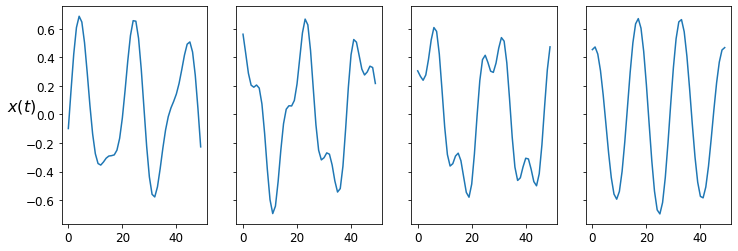

In [37]:
# plot the dataset

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
for col in range(4):
    plt.sca(axes[col])
    plt.plot(_series[col, :])
    if col == 0:
        plt.ylabel("$x(t)$", fontsize=16, rotation=0)
plt.show()

In [ ]:
# the above figure shows 4 different series of the sine waves

In [40]:
# generate series in a time series

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [9]:
n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps + 1)
series

array([[[-0.0156356 ],
        [-0.13100033],
        [-0.17780298],
        ...,
        [ 0.42920184],
        [ 0.22676936],
        [ 0.03527924]],

       [[-0.132342  ],
        [-0.02629057],
        [ 0.29225808],
        ...,
        [ 0.32331413],
        [ 0.30041876],
        [ 0.32997766]],

       [[-0.6574495 ],
        [-0.5360261 ],
        [-0.4185448 ],
        ...,
        [ 0.30824453],
        [ 0.29834875],
        [ 0.3153986 ]],

       ...,

       [[-0.16535792],
        [-0.1874328 ],
        [-0.20875804],
        ...,
        [ 0.24855247],
        [ 0.2946811 ],
        [ 0.34965265]],

       [[-0.64275914],
        [-0.5260949 ],
        [-0.25060016],
        ...,
        [-0.29491508],
        [-0.5461737 ],
        [-0.6057572 ]],

       [[ 0.30862015],
        [ 0.1831635 ],
        [ 0.02065332],
        ...,
        [-0.14246574],
        [-0.33199337],
        [-0.5548359 ]]], dtype=float32)

In [7]:
series.shape

(10000, 51, 1)

## Split dataset into train and test set

In [12]:
# train test split is done sequentially (not randmly with sklearn)
# since we are training on a time series and validating and testing on future data

test_size = 0.1
validation_size = 0.2
n_valid = int(batch_size * validation_size)
n_test = int(batch_size * test_size)
n_train = batch_size - n_valid - n_test
X_train, y_train = series[:n_train, :n_steps], series[:n_train, -1]
X_valid, y_valid = series[n_train:n_train+n_valid, :n_steps], series[n_train:n_train+n_valid, -1]
X_test, y_test = series[n_train+n_valid:, :n_steps], series[n_train+n_valid:, -1]

In [16]:
print("X_train.shape ", X_train.shape)
print("y_train.shape ", y_train.shape)
print("X_test.shape ", X_test.shape)
print("y_test.shape ", y_test.shape)
print("X_valid.shape ", X_valid.shape)
print("y_valid.shape ", y_valid.shape)


X_train.shape  (7000, 50, 1)
y_train.shape  (7000, 1)
X_test.shape  (1000, 50, 1)
y_test.shape  (1000, 1)
X_valid.shape  (2000, 50, 1)
y_valid.shape  (2000, 1)


## Plot the dataset

In [46]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    n_steps = series.shape[0]
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])



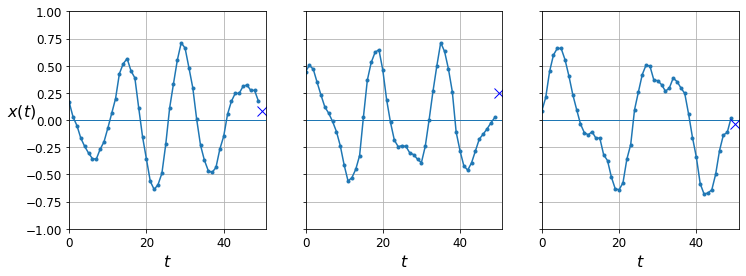

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [18]:
X_valid.shape

(2000, 50, 1)

# Baseline

In [48]:
# predict the last observed value

# X contains all the points in the sine wave except for the last value
y_pred = X_valid[:, -1]
y_pred

array([[ 0.1739547 ],
       [ 0.02383144],
       [ 0.02014733],
       ...,
       [-0.6158054 ],
       [-0.58821124],
       [ 0.59003717]], dtype=float32)

In [55]:
# mean squered error:

base_mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
base_mse

0.020685406

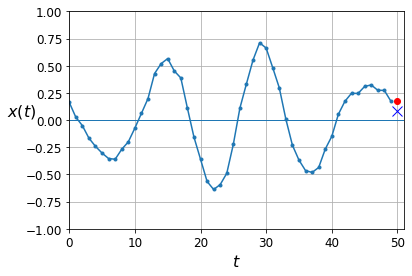

In [50]:
# example plot

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Linear prediction with tensorflow

In [52]:
# linear prediction with tf: one input layer, and one output layer.
# The connection represents the weights in a simple linear model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile()
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 839us/step - loss: 0.1013 - val_loss: 0.0563
Epoch 2/20
219/219 [==============================] - 0s 525us/step - loss: 0.0404 - val_loss: 0.0284
Epoch 3/20
219/219 [==============================] - 0s 579us/step - loss: 0.0216 - val_loss: 0.0166
Epoch 4/20
219/219 [==============================] - 0s 531us/step - loss: 0.0136 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 0s 529us/step - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
219/219 [==============================] - 0s 528us/step - loss: 0.0088 - val_loss: 0.0085
Epoch 7/20
219/219 [==============================] - 0s 513us/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/20
219/219 [==============================] - 0s 526us/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 529us/step - loss: 0.0066 - val_loss: 0.0064
Epoch 10/20
219/219 [==============================] - 0s 533us/step - loss: 0.006

In [54]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 408us/step - loss: 0.0041


0.004059051629155874

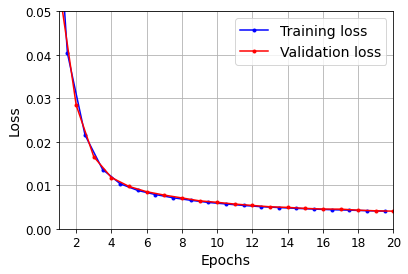

In [56]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

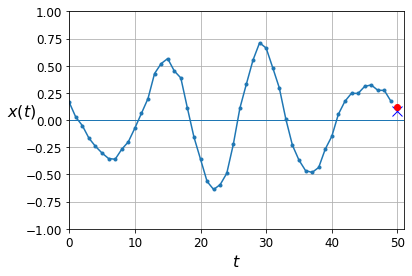

In [57]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Simple RNN

In [58]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0326 - val_loss: 0.0129
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0114

In [59]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0113


0.011313444934785366

In [ ]:
# just slightly better than baseline

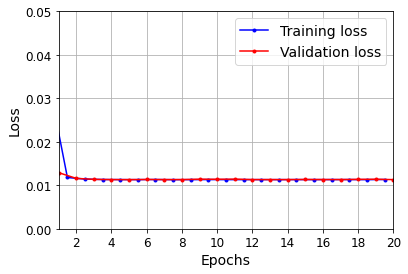

In [60]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [61]:
# quickly converges at a poor result

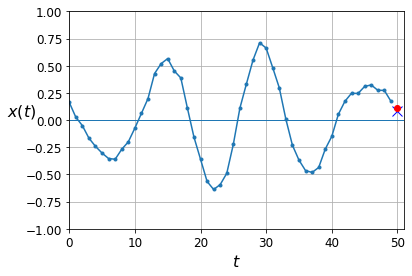

In [62]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Deep RNN

In [63]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0196 - val_loss: 0.0055
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0029 - val_lo

In [64]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0028


0.0027979351580142975

In [66]:
# we can see that the deep RNN is 5 times better than simple RNN and ~2 times better than linear regression


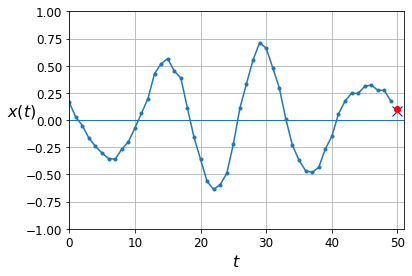

In [67]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Modified Deep RNN

In [80]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return only the last output
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0171 - val_loss: 0.0055
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0029 - val_lo

In [69]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.0028560925275087357

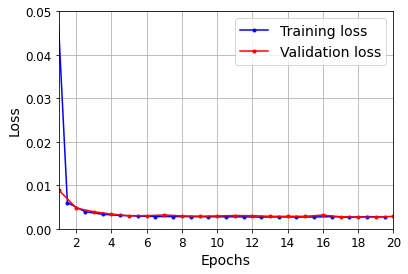

In [70]:

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

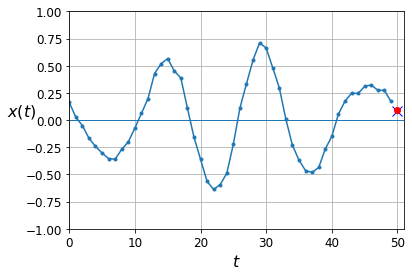

In [71]:

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Forecasting

In [81]:
np.random.seed(43) # create a different series
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [85]:
X.shape

(1, 60, 1)

In [89]:
Y_pred.shape

(1, 10, 1)

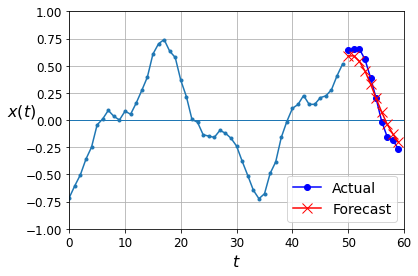

In [92]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()